From https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import edward2 as ed
%matplotlib inline
plt.style.use('ggplot')

In [4]:
def load_insteval():
    url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/lme4/InstEval.csv')
    with requests.Session() as s:
        download = s.get(url)
        f = download.content.decode().splitlines()
    iterator = csv.reader(f)
    columns = next(iterator)[1:]
    x_train = np.array([row[1:] for row in iterator], dtype=np.int)
    metadata = {'columns': columns}
    return x_train, metadata

In [5]:
data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,students,instructors,studage,lectage,service,departments,ratings
28876,1176,1062,6,6,1,7,2
59848,2420,677,6,4,1,5,3
2500,99,902,8,5,0,10,5
22015,888,1023,8,4,1,7,5
55054,2213,903,4,2,1,2,5


In [6]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']}
labels_train = get_value(train, key='ratings', dtype=np.float32)

features_test = {k: get_value(test, key=k, dtype=np.int32)
                 for k in ['students', 'instructors', 'departments', 'service']}
labels_test = get_value(test, key='ratings', dtype=np.float32)

In [7]:
num_students = max(features_train['students']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]

print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


In [8]:
def linear_mixed_effects_model(features):
    # Set up fixed effects and other parameters.
    intercept = tf.get_variable("intercept", [])  # alpha in eq
    effect_service = tf.get_variable("effect_service", [])  # beta in eq
    stddev_students = tf.exp(
        tf.get_variable("stddev_unconstrained_students", []))  # sigma in eq
    stddev_instructors = tf.exp(
        tf.get_variable("stddev_unconstrained_instructors", [])) # sigma in eq
    stddev_departments = tf.exp(
        tf.get_variable("stddev_unconstrained_departments", [])) # sigma in eq
  
    # Set up random effects.
    effect_students = ed.MultivariateNormalDiag(
        loc=tf.zeros(num_students),
        scale_identity_multiplier=stddev_students,
        name="effect_students")
    effect_instructors = ed.MultivariateNormalDiag(
        loc=tf.zeros(num_instructors),
        scale_identity_multiplier=stddev_instructors,
        name="effect_instructors")
    effect_departments = ed.MultivariateNormalDiag(
        loc=tf.zeros(num_departments),
        scale_identity_multiplier=stddev_departments,
        name="effect_departments")
  
    # Set up likelihood given fixed and random effects.
    # Note we use `tf.gather` instead of matrix-multiplying a design matrix of
    # one-hot vectors. The latter is memory-intensive if there are many groups.
    ratings = ed.Normal(
        loc=(effect_service * features["service"] +
             tf.gather(effect_students, features["students"]) +
             tf.gather(effect_instructors, features["instructors"]) +
             tf.gather(effect_departments, features["departments"]) +
             intercept),
        scale=1.,
        name="ratings")
    return ratings

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", linear_mixed_effects_model)

In [9]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def draw_graph(model, *args, **kwargs):
    """Visualize TensorFlow graph."""
    graph = tf.Graph()
    with graph.as_default():
        model(*args, **kwargs)
    graph_def = graph.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=32)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    IPython.display.display(IPython.display.HTML(iframe))


draw_graph(linear_mixed_effects_model, features_train)

In [10]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(effect_students, effect_instructors, effect_departments):
  """Unnormalized target density as a function of states."""
  return log_joint(  # fix `features` and `ratings` to the training data
    features=features_train,
    effect_students=effect_students,
    effect_instructors=effect_instructors,
    effect_departments=effect_departments,
    ratings=labels_train)

tf.reset_default_graph()

# Set up E-step (MCMC).
effect_students = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_students", [num_students], trainable=False)
effect_instructors = tf.get_variable(
    "effect_instructors", [num_instructors], trainable=False)
effect_departments = tf.get_variable(
    "effect_departments", [num_departments], trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)

current_state = [effect_students, effect_instructors, effect_departments]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

expectation_update = tf.group(
    effect_students.assign(next_state[0]),
    effect_instructors.assign(next_state[1]),
    effect_departments.assign(next_state[2]))

# Set up M-step (gradient descent).
# The following should work. However, TensorFlow raises an error about taking
# gradients through IndexedSlices tensors. This may be a TF bug. For now,
# we recompute the target's log probability at the current state.
# loss = -kernel_results.accepted_results.target_log_prob
with tf.control_dependencies([expectation_update]):
    loss = -target_log_prob_fn(effect_students,
                               effect_instructors,
                               effect_departments)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    minimization_update = optimizer.minimize(loss)

In [11]:
init = tf.global_variables_initializer()

num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)

# Run warm-up stage.
for t in range(num_warmup_iters):
    _, is_accepted_val = sess.run(
        [expectation_update, kernel_results.is_accepted])
    num_accepted += is_accepted_val
    if t % 500 == 0 or t == num_warmup_iters - 1:
        print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
    for _ in range(5):  # run 5 MCMC iterations before every joint EM update
        _ = sess.run(expectation_update)
    [
        _,
        _,
        effect_students_val,
        effect_instructors_val,
        effect_departments_val,
        is_accepted_val,
        loss_val,
    ] = sess.run([
        expectation_update,
        minimization_update,
        effect_students,
        effect_instructors,
        effect_departments,
        kernel_results.is_accepted,
        loss,
    ])
    effect_students_samples[t, :] = effect_students_val
    effect_instructors_samples[t, :] = effect_instructors_val
    effect_departments_samples[t, :] = effect_departments_val
    num_accepted += is_accepted_val
    loss_history[t] = loss_val
    if t % 500 == 0 or t == num_iters - 1:
        print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(t, num_accepted / (t + 1), loss_val))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.774
Warm-Up Iteration: 999 Acceptance Rate: 0.734
Iteration:    0 Acceptance Rate: 1.000 Loss: 103253.273
Iteration:  500 Acceptance Rate: 0.693 Loss: 96088.594
Iteration: 1000 Acceptance Rate: 0.687 Loss: 96019.188
Iteration: 1499 Acceptance Rate: 0.679 Loss: 95957.445


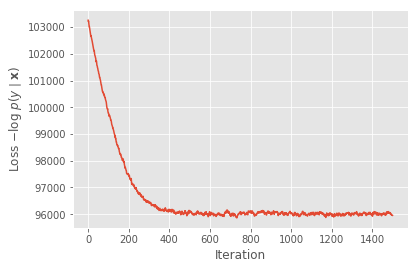

In [12]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

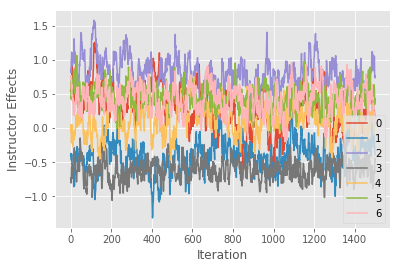

In [13]:
for i in range(7):
    plt.plot(effect_instructors_samples[:, i])

plt.legend([i for i in range(7)], loc='lower right')
plt.ylabel('Instructor Effects')
plt.xlabel('Iteration')
plt.show()

In [14]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
    """Replaces prior on effects with empirical posterior mean from MCMC."""
    name = rv_kwargs.pop("name")
    if name == "effect_students":
        rv_kwargs["value"] = np.mean(effect_students_samples, 0)
    elif name == "effect_instructors":
        rv_kwargs["value"] = np.mean(effect_instructors_samples, 0)
    elif name == "effect_departments":
        rv_kwargs["value"] = np.mean(effect_departments_samples, 0)
    return rv_constructor(*rv_args, **rv_kwargs)

with ed.interception(interceptor):
    ratings_posterior = model_template(features=features_test)

ratings_prediction = ratings_posterior.distribution.mean()

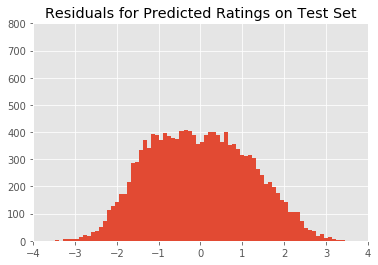

In [15]:
ratings_pred = sess.run(ratings_prediction)
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_pred - labels_test, 75)
plt.show()

In [21]:
[
    effect_students_mean,
    effect_instructors_mean,
    effect_departments_mean,
] = sess.run([
    tf.reduce_mean(effect_students_samples, 0),
    tf.reduce_mean(effect_instructors_samples, 0),
    tf.reduce_mean(effect_departments_samples, 0),
])

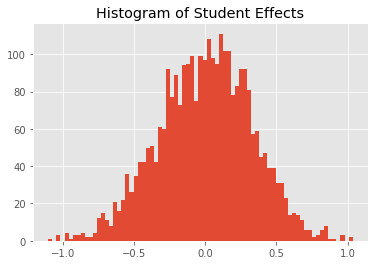

In [17]:
plt.title("Histogram of Student Effects")
plt.hist(effect_students_mean, 75)
plt.show()

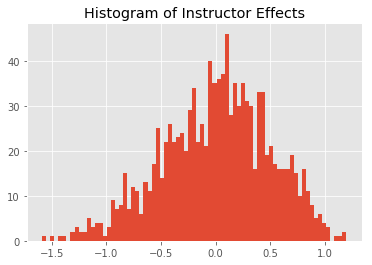

In [18]:
plt.title("Histogram of Instructor Effects")
plt.hist(effect_instructors_mean, 75)
plt.show()

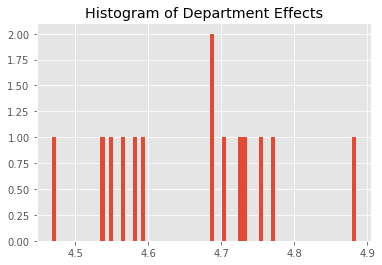

In [20]:
plt.title("Histogram of Department Effects")
plt.hist(effect_departments_mean, 75)
plt.show()